In [1]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory as idfd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

print(tf.config.list_physical_devices('GPU'))
keras.mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, compute capability 7.5


In [2]:
'''

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d sanikamal/rock-paper-scissors-dataset
! unzip rock-paper-scissors-dataset.zip

'''

'! pip install kaggle\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json'

In [4]:
train_path = "path to\Rock-Paper-Scissors\train"
test_path = "path to\Rock-Paper-Scissors\test"

In [5]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32

In [8]:
train_dataset = idfd(train_path,
                     image_size=IMAGE_SIZE,
                     batch_size=BATCH_SIZE,
                     label_mode='int',
                     labels='inferred',
                     color_mode="rgb",
                     validation_split=0.25,
                     subset="training",
                     seed=42)

val_dataset = idfd(train_path,
                   image_size=IMAGE_SIZE,
                   batch_size=BATCH_SIZE,
                   label_mode='int',
                   labels='inferred',
                   color_mode="rgb",
                   validation_split=0.25,
                   subset="validation",
                   seed=42)

test_dataset = idfd(test_path,
                    image_size=IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    label_mode='int',
                    labels='inferred',
                    color_mode="rgb")

Found 2520 files belonging to 3 classes.
Using 1890 files for training.
Found 2520 files belonging to 3 classes.
Using 630 files for validation.
Found 372 files belonging to 3 classes.


In [10]:
#Importing ResNet50

conv_base = keras.applications.ResNet50(include_top=False,
                                        weights='imagenet',
                                        input_shape=(300, 300, 3))


conv_base.trainable = False
#conv_base.summary()

In [11]:
#Defining Model

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])


inputs = keras.Input(shape=(300, 300, 3))
x = data_aug(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = conv_base(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(
     filepath="rps.keras",
     save_best_only=True,
     monitor="val_loss")]


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                             

In [12]:
#Training the model

callbacks = [keras.callbacks.ModelCheckpoint(
     filepath="rps.keras",
     save_best_only=True,
     monitor="val_loss")]

history = model.fit(
 train_dataset,
 epochs=50,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/50
60/60 [==============================] - 47s 692ms/step - loss: 4.8011 - accuracy: 0.7106 - val_loss: 0.0042 - val_accuracy: 0.9984
Epoch 2/50
60/60 [==============================] - 40s 664ms/step - loss: 0.3357 - accuracy: 0.9275 - val_loss: 0.0150 - val_accuracy: 0.9968
Epoch 3/50
60/60 [==============================] - 41s 687ms/step - loss: 0.1041 - accuracy: 0.9635 - val_loss: 0.0020 - val_accuracy: 0.9984
Epoch 4/50
60/60 [==============================] - 40s 670ms/step - loss: 0.0441 - accuracy: 0.9873 - val_loss: 0.0068 - val_accuracy: 0.9984
Epoch 5/50
60/60 [==============================] - 40s 671ms/step - loss: 0.0229 - accuracy: 0.9899 - val_loss: 0.0127 - val_accuracy: 0.9968
Epoch 6/50
60/60 [==============================] - 40s 675ms/step - loss: 0.0501 - accuracy: 0.9836 - val_loss: 0.0039 - val_accuracy: 0.9984
Epoch 7/50
60/60 [==============================] - 40s 676ms/step - loss: 0.0695 - accuracy: 0.9804 - val_loss: 0.0031 - val_accuracy: 0.9984

In [15]:
model = keras.models.load_model("rps.keras")
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

12/12 [==============================] - 6s 450ms/step - loss: 0.1520 - accuracy: 0.9785
Test accuracy: 0.978


# Plotting Accuracy and Loss

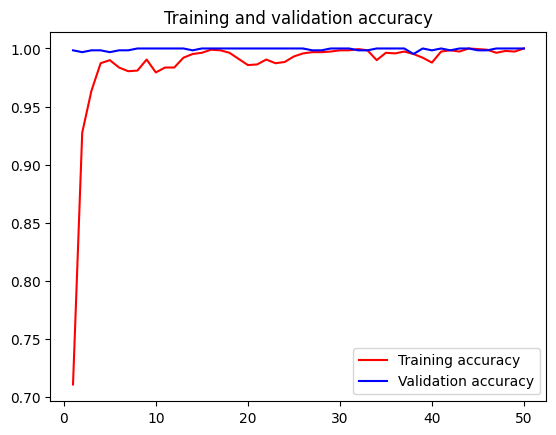

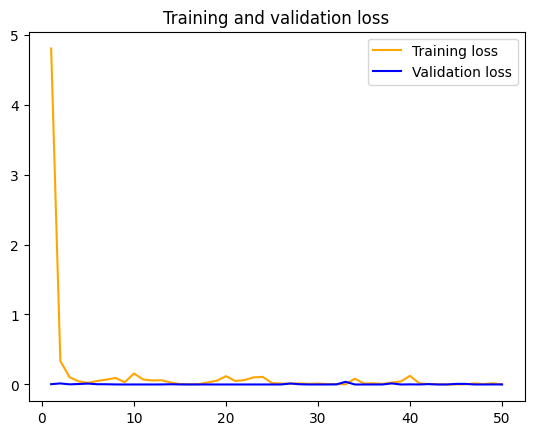

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color='red', label="Training accuracy")
plt.plot(epochs, val_acc, color='blue', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color='orange', label="Training loss")
plt.plot(epochs, val_loss, color='blue', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Plots from 5th epoch onwards for better visualization

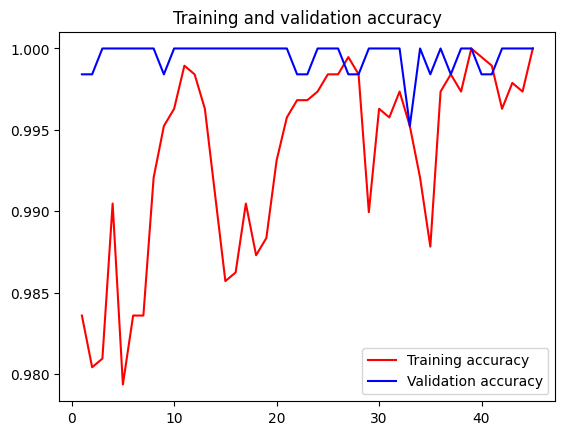

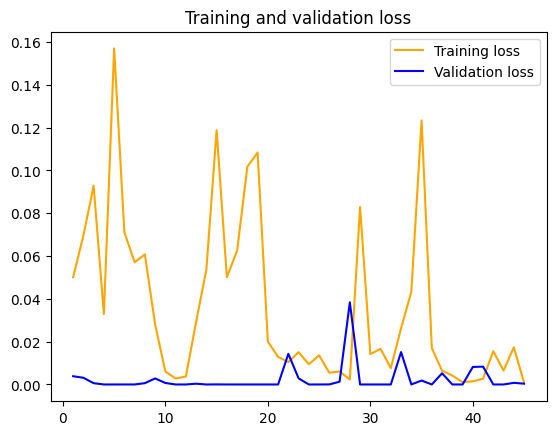

In [17]:
acc = history.history["accuracy"][5:]
val_acc = history.history["val_accuracy"][5:]

loss = history.history["loss"][5:]
val_loss = history.history["val_loss"][5:]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color='red', label="Training accuracy")
plt.plot(epochs, val_acc, color='blue', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color='orange', label="Training loss")
plt.plot(epochs, val_loss, color='blue', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()